# Enhanced Demand Forecasting using XGBoost with Daily Data
This script performs demand forecasting using daily demand data combined with monthly economic indicators.

## Import Libraries and Load Data

In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns   

# Load daily data
daily_df = pd.read_excel(
    r"C:\Users\k_pow\OneDrive\Documents\MIT\MITx SCM\IAP 2025\SCC\Customer Order Quantity_Dispatched Quantity.xlsx"
)

# Filter for Material_4
material_id = '000161032'  # Material_4
material_no = 'Material_4'
daily_df = daily_df[daily_df['Product ID'] == material_id].copy()

# Convert date column
daily_df['Date'] = pd.to_datetime(daily_df['Date'], format='%d.%m.%Y')
daily_df.set_index('Date', inplace=True)
daily_df.sort_index(inplace=True)

# Load monthly data with external variables
monthly_df = pd.read_csv(r'C:\Users\k_pow\OneDrive\Documents\MIT\MITx SCM\IAP 2025\SCC\Data_files\0001O1010_Material_51.csv')
monthly_df['YearMonth'] = pd.to_datetime(monthly_df['YearMonth'])
monthly_df.set_index('YearMonth', inplace=True)

print("Data loaded successfully.")
print("Daily data shape:", daily_df.shape)
print("Monthly data shape:", monthly_df.shape)

Data loaded successfully.
Daily data shape: (920, 7)
Monthly data shape: (95, 11)


In [2]:
daily_df

,Product ID,Product Name,Customer Order Quantity,Dispatched Quantity,Year,Month,Day
Date,,,,,,,
2022-01-03,000161032,Material_4,0,120,2022,1,3
2022-01-04,000161032,Material_4,0,75,2022,1,4
2022-01-05,000161032,Material_4,0,51,2022,1,5
2022-01-06,000161032,Material_4,0,246,2022,1,6
2022-01-07,000161032,Material_4,0,40,2022,1,7
...,...,...,...,...,...,...,...
2024-11-28,000161032,Material_4,0,92,2024,11,28
2024-11-29,000161032,Material_4,0,110,2024,11,29
2024-11-30,000161032,Material_4,0,30,2024,11,30


In [3]:
# Create a complete date range from the minimum to the maximum date
full_date_range = pd.date_range(start='2022-01-01', end='2024-12-05', freq='D')

# Reindex the dataframe to include all dates, filling missing values with 0
daily_df = daily_df.reindex(full_date_range, fill_value=0)

# Re-add the static 'Product ID' and 'Product Name' since they remain constant
daily_df['Product ID'] = material_no  
daily_df['Product Name'] = material_id  

# Re-add Year, Month, Day columns
daily_df['Year'] = daily_df.index.year
daily_df['Month'] = daily_df.index.month
daily_df['Day'] = daily_df.index.day

daily_df.head(60)

,Product ID,Product Name,Customer Order Quantity,Dispatched Quantity,Year,Month,Day
2022-01-01,Material_4,000161032,0,0,2022,1,1
2022-01-02,Material_4,000161032,0,0,2022,1,2
2022-01-03,Material_4,000161032,0,120,2022,1,3
2022-01-04,Material_4,000161032,0,75,2022,1,4
2022-01-05,Material_4,000161032,0,51,2022,1,5
2022-01-06,Material_4,000161032,0,246,2022,1,6
2022-01-07,Material_4,000161032,0,40,2022,1,7
2022-01-08,Material_4,000161032,0,89,2022,1,8
2022-01-09,Material_4,000161032,0,0,2022,1,9
2022-01-10,Material_4,000161032,0,0,2022,1,10


<Axes: xlabel='None', ylabel='Customer Order Quantity'>

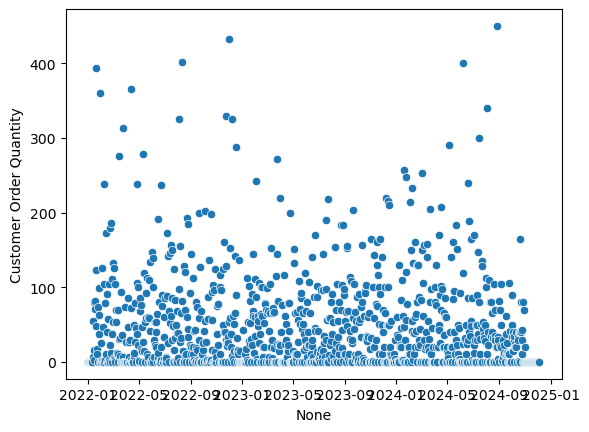

In [4]:
sns.scatterplot(x=daily_df.index, y=daily_df['Customer Order Quantity'])

In [5]:
monthly_df

,Product ID,Product Name,Dispatched Quantity,Customer Order Quantity,ECG_DESP,TUAV,PIB_CO,ISE_CO,VTOTAL_19,OTOTAL_19,ICI
YearMonth,,,,,,,,,,,
2017-01-01,0001O1010,Material_51,0.0,0.0,9.131904e+05,11303.0,14517.735830,100.730076,17178.0,133721.0,1.90
2017-02-01,0001O1010,Material_51,0.0,0.0,1.007968e+06,16187.0,14517.735830,101.167441,16175.0,130854.0,-0.10
2017-03-01,0001O1010,Material_51,0.0,0.0,1.083268e+06,15231.0,14517.735830,100.377762,15333.0,137551.0,-0.90
2017-04-01,0001O1010,Material_51,0.0,0.0,9.000049e+05,14093.0,14985.508742,103.507894,14456.0,135700.0,-8.50
2017-05-01,0001O1010,Material_51,0.0,0.0,9.990460e+05,13645.0,14985.508742,102.634285,14281.0,136432.0,-8.80
...,...,...,...,...,...,...,...,...,...,...,...
2024-07-01,0001O1010,Material_51,1496.0,866.0,1.050528e+06,13092.0,10752.586638,74.110006,12248.0,165294.0,-1.19
2024-08-01,0001O1010,Material_51,1341.0,1180.0,1.074200e+06,14486.0,10752.586638,74.788896,13963.0,166207.0,-1.42
2024-09-01,0001O1010,Material_51,916.0,1063.0,1.003767e+06,17833.0,10752.586638,73.813056,10856.0,166496.0,1.34


## Prepare Features

In [8]:
def prepare_features(daily_data, monthly_data):
    """Prepare features combining daily and monthly data."""
    features = pd.DataFrame(index=daily_data.index)
    
    # Basic demand lags
    for lag in [1, 2, 3, 7, 14, 30, 60, 90, 180, 360, 720]:
        features[f'Demand_lag_{lag}d'] = daily_data['Dispatched Quantity'].shift(lag)
    
    # Rolling statistics
    for window in [7, 14, 30, 60, 90]:
        roll = daily_data['Dispatched Quantity'].rolling(window=window, min_periods=1)
        features[f'Demand_roll_mean_{window}d'] = roll.mean()
        features[f'Demand_roll_std_{window}d'] = roll.std()
        features[f'Demand_roll_max_{window}d'] = roll.max()
        features[f'Demand_roll_min_{window}d'] = roll.min()
    
    # External variables
    external_vars = ['ECG_DESP', 'TUAV', 'PIB_CO', 'ISE_CO', 'VTOTAL_19', 'OTOTAL_19', 'ICI']
    for var in external_vars:
        if var in monthly_data.columns:
            # Monthly lags
            for lag in range(1, 7):
                features[f'{var}_lag_{lag}m'] = monthly_data[var].shift(lag).reindex(daily_data.index).ffill()
            
            # Rolling means
            roll3m = monthly_data[var].rolling(window=3, min_periods=1)
            roll6m = monthly_data[var].rolling(window=6, min_periods=1)
            features[f'{var}_roll_mean_3m'] = roll3m.mean().reindex(daily_data.index).ffill()
            features[f'{var}_roll_mean_6m'] = roll6m.mean().reindex(daily_data.index).ffill()
    
    # Seasonality features
    features['Month'] = daily_data.index.month
    features['Quarter'] = daily_data.index.quarter
    features['WeekOfYear'] = daily_data.index.isocalendar().week
    features['DayOfWeek'] = daily_data.index.dayofweek
    features['DayOfMonth'] = daily_data.index.day
    
    # Cyclical encoding
    features['Month_sin'] = np.sin(2 * np.pi * daily_data.index.month / 12)
    features['Month_cos'] = np.cos(2 * np.pi * daily_data.index.month / 12)
    features['Week_sin'] = np.sin(2 * np.pi * daily_data.index.isocalendar().week / 52)
    features['Week_cos'] = np.cos(2 * np.pi * daily_data.index.isocalendar().week / 52)
    features['Day_sin'] = np.sin(2 * np.pi * daily_data.index.dayofweek / 7)
    features['Day_cos'] = np.cos(2 * np.pi * daily_data.index.dayofweek / 7)
    
    # Year-over-year features
    features['Demand_SameDayLastYear'] = daily_data['Dispatched Quantity'].shift(365)
    features['Demand_SameWeekLastYear'] = daily_data['Dispatched Quantity'].shift(364).rolling(7).mean()
    features['Demand_SameMonthLastYear'] = daily_data['Dispatched Quantity'].shift(365).rolling(30).mean()
    
    # Customer order features
    for lag in [1, 2, 3, 7, 14, 30]:
        features[f'Customer_Order_Lag{lag}'] = daily_data['Customer Order Quantity'].shift(lag)
        ratio = (daily_data['Customer Order Quantity'].shift(lag) / 
                daily_data['Dispatched Quantity'].shift(lag))
        features[f'Order_Demand_Ratio_Lag{lag}'] = ratio.replace([np.inf, -np.inf], np.nan)
    
    return features.fillna(0)

# Prepare features
features_df = prepare_features(daily_df, monthly_df)
target = daily_df['Dispatched Quantity']

C:\Users\k_pow\AppData\Local\Temp\ipykernel_24872\2162859548.py:53: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  features[f'Customer_Order_Lag{lag}'] = daily_data['Customer Order Quantity'].shift(lag)
C:\Users\k_pow\AppData\Local\Temp\ipykernel_24872\2162859548.py:56: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  features[f'Order_Demand_Ratio_Lag{lag}'] = ratio.replace([np.inf, -np.inf], np.nan)
C:\Users\k_pow\AppData\Local\Temp\ipykernel_24872\2162859548.py:53: PerformanceWarning: DataFrame is highly fragmented.  This is usual

## Split Data and Train Model

In [9]:
# Split data based on date
train_cutoff = pd.to_datetime('2024-06-01')
train_mask = features_df.index < train_cutoff

X_train = features_df[train_mask]
y_train = target[train_mask]
X_test = features_df[~train_mask]
y_test = target[~train_mask]

print("Training data shape:", X_train.shape)
print("Test data shape:", X_test.shape)

# Train XGBoost model
model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=100,
    learning_rate=0.05,
    max_depth=4,
    min_child_weight=2,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

# Train the model
model.fit(
    X_train, 
    y_train,
    eval_set=[(X_test, y_test)],
    verbose=False
)

print("Model training completed")

Training data shape: (761, 113)
Test data shape: (159, 113)
Model training completed


## Evaluate Model at Multiple Time Scales

In [10]:
# Make daily predictions
daily_pred = model.predict(X_test)

# Create DataFrames with actual and predicted values at different scales
daily_results = pd.DataFrame({
    'Date': X_test.index,
    'Actual': y_test,
    'Predicted': daily_pred
})

# Aggregate to weekly
weekly_actual = y_test.resample('W-MON').mean()
weekly_pred = pd.Series(daily_pred, index=X_test.index).resample('W-MON').mean()
weekly_results = pd.DataFrame({
    'Date': weekly_actual.index,
    'Actual': weekly_actual,
    'Predicted': weekly_pred
})

# Aggregate to monthly
monthly_actual = y_test.resample('MS').mean()
monthly_pred = pd.Series(daily_pred, index=X_test.index).resample('MS').mean()
monthly_results = pd.DataFrame({
    'Date': monthly_actual.index,
    'Actual': monthly_actual,
    'Predicted': monthly_pred
})

# Calculate metrics for each time scale
def calculate_metrics(actual, pred):
    return {
        'RMSE': np.sqrt(mean_squared_error(actual, pred)),
        'MAE': mean_absolute_error(actual, pred),
        'R2': r2_score(actual, pred)
    }

daily_metrics = calculate_metrics(daily_results['Actual'], daily_results['Predicted'])
weekly_metrics = calculate_metrics(weekly_results['Actual'], weekly_results['Predicted'])
monthly_metrics = calculate_metrics(monthly_results['Actual'], monthly_results['Predicted'])

print("\nModel Performance Metrics:")
print("\nDaily Metrics:")
print(f"RMSE: {daily_metrics['RMSE']:.2f}")
print(f"MAE: {daily_metrics['MAE']:.2f}")
print(f"R2: {daily_metrics['R2']:.3f}")

print("\nWeekly Metrics:")
print(f"RMSE: {weekly_metrics['RMSE']:.2f}")
print(f"MAE: {weekly_metrics['MAE']:.2f}")
print(f"R2: {weekly_metrics['R2']:.3f}")

print("\nMonthly Metrics:")
print(f"RMSE: {monthly_metrics['RMSE']:.2f}")
print(f"MAE: {monthly_metrics['MAE']:.2f}")
print(f"R2: {monthly_metrics['R2']:.3f}")


Model Performance Metrics:

Daily Metrics:
RMSE: 63.69
MAE: 44.46
R2: 0.174

Weekly Metrics:
RMSE: 33.20
MAE: 22.64
R2: 0.110

Monthly Metrics:
RMSE: 39.05
MAE: 17.30
R2: 0.003


## Visualize Results at Different Time Scales

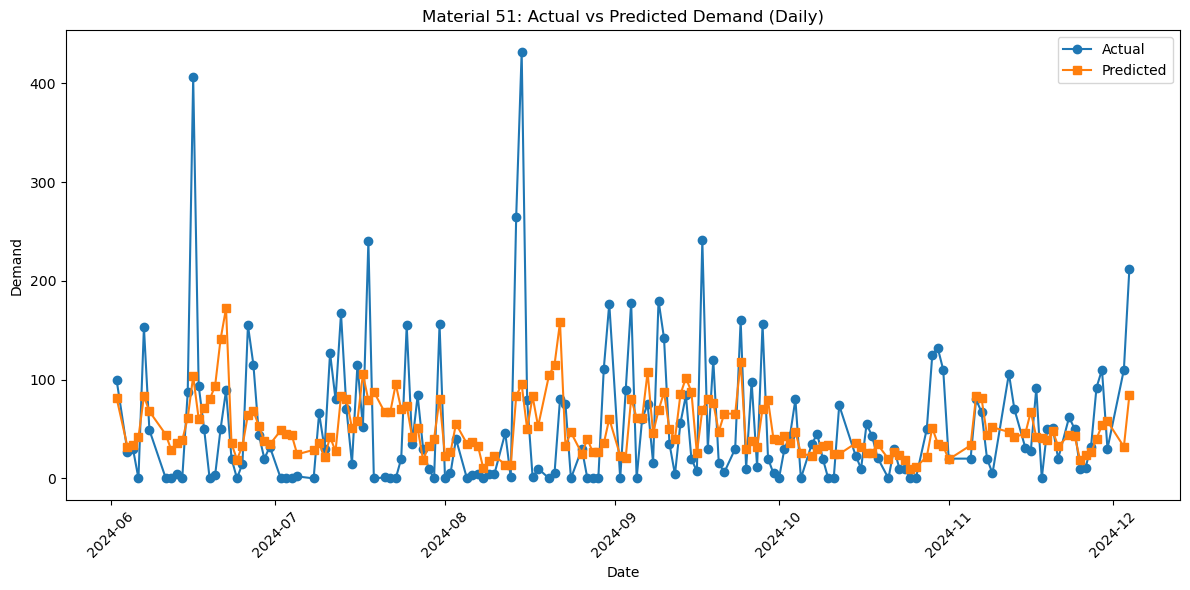

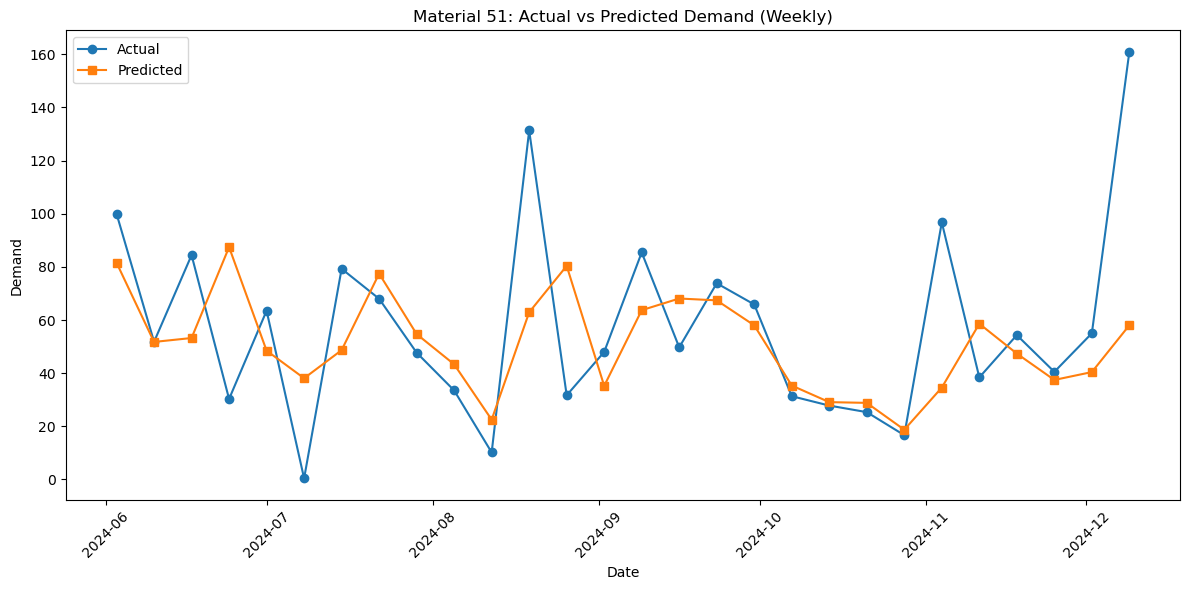

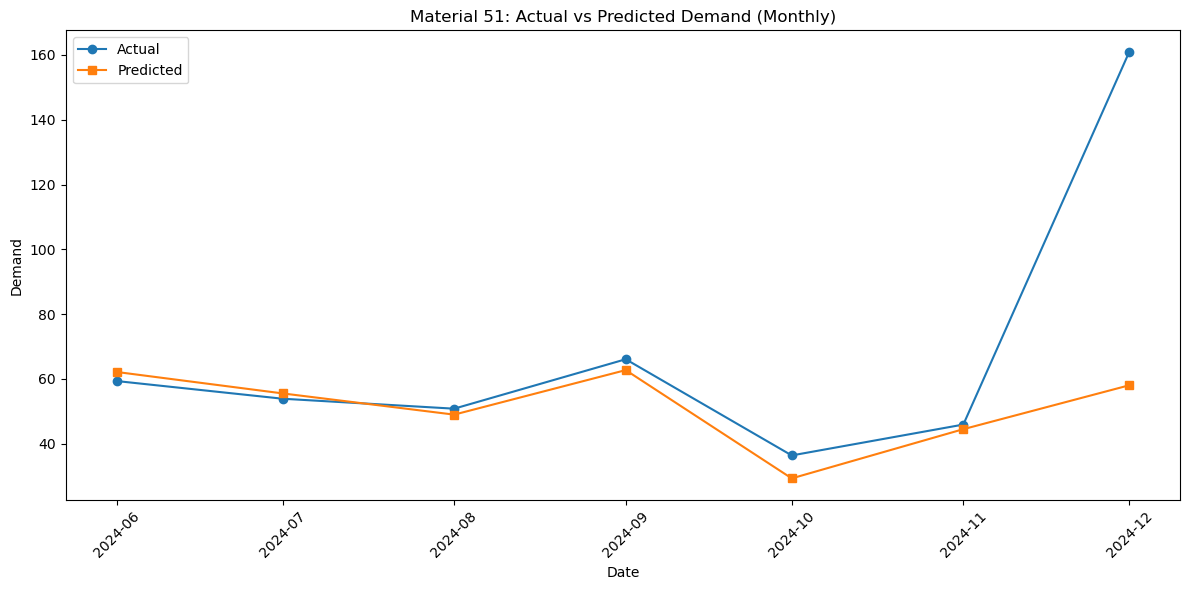

In [11]:
def plot_predictions(results, title, freq):
    plt.figure(figsize=(12, 6))
    plt.plot(results['Date'], results['Actual'], label='Actual', marker='o')
    plt.plot(results['Date'], results['Predicted'], label='Predicted', marker='s')
    plt.title(f'Material 51: Actual vs Predicted Demand ({freq})')
    plt.xlabel('Date')
    plt.ylabel('Demand')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Plot results at different time scales
plot_predictions(daily_results, 'Daily Predictions', 'Daily')
plot_predictions(weekly_results, 'Weekly Predictions', 'Weekly')
plot_predictions(monthly_results, 'Monthly Predictions', 'Monthly')

## Feature Importance Analysis

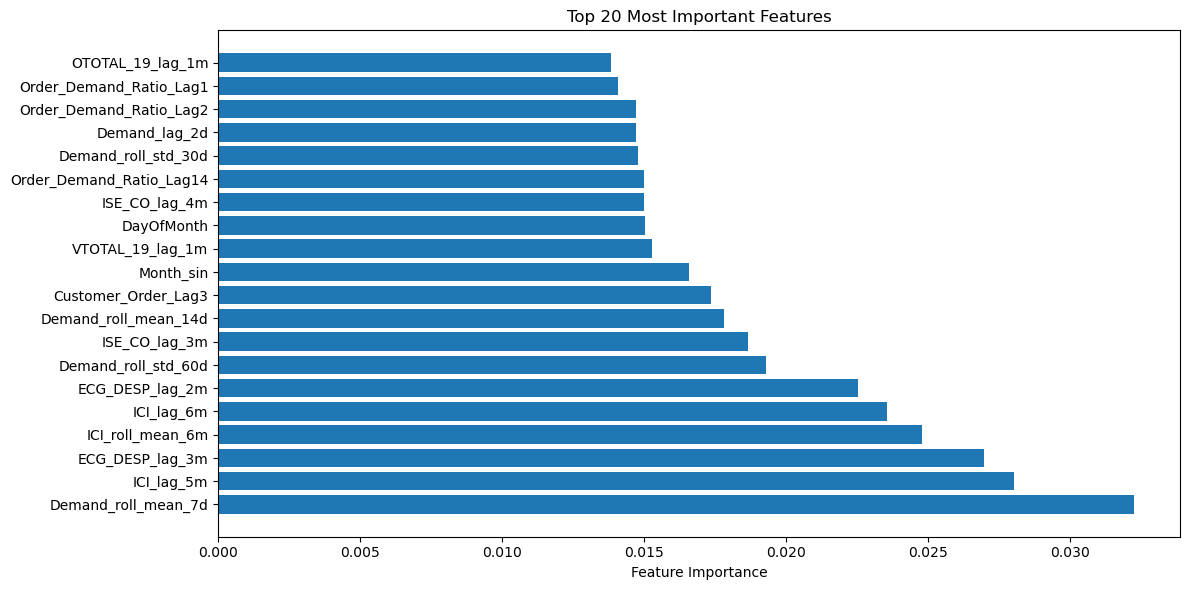


Top 10 Most Important Features:
                  feature  importance
11    Demand_roll_mean_7d    0.032272
83             ICI_lag_5m    0.028020
33        ECG_DESP_lag_3m    0.026992
86       ICI_roll_mean_6m    0.024783
84             ICI_lag_6m    0.023554
32        ECG_DESP_lag_2m    0.022524
24    Demand_roll_std_60d    0.019291
57          ISE_CO_lag_3m    0.018663
15   Demand_roll_mean_14d    0.017812
105   Customer_Order_Lag3    0.017362


In [12]:
# Get feature importance
importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

# Plot top 20 features
plt.figure(figsize=(12, 6))
plt.barh(importance.head(20)['feature'], importance.head(20)['importance'])
plt.title('Top 20 Most Important Features')
plt.xlabel('Feature Importance')
plt.tight_layout()
plt.show()

print("\nTop 10 Most Important Features:")
print(importance.head(10))